In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, box
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [2]:
nodes = pd.read_csv("node_data.csv")
edges = pd.read_csv("edges_data.csv")
df_2020 = pd.read_csv("data/scats_detector_volume_jan-jun-2020.csv")
sites = pd.read_csv("data/its_scats_sites_aug-2020.csv")
columns_to_load = ["End_Time", "Site", "Detector", "Sum_Volume", "Avg_Volume"]
March2025 = pd.read_csv("data/SCATSMarch2025.csv", usecols=columns_to_load)
April2025 = pd.read_csv("data/SCATSApril2025.csv", usecols=columns_to_load)
May2025 = pd.read_csv("data/SCATSMay2025.csv", usecols=columns_to_load)

In [3]:
df  = pd.concat([March2025, April2025], ignore_index=True)

In [4]:
geo_edges=edges.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_edges['geometry'] = edges['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_edges = gpd.GeoDataFrame(geo_edges, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_edges.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_edges))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [5]:
geo_nodes=nodes.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_nodes = gpd.GeoDataFrame(geo_nodes, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_nodes.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_nodes))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [6]:
sites = sites[~((sites["Lat"] == 0) | (sites["Long"] == 0))]
geo_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites['Long'], sites['Lat']),
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)

In [7]:
# Get bounding box of all points
minx, miny, maxx, maxy = geo_edges.total_bounds

# Define grid size (in the CRS units, e.g., degrees if EPSG:4326)
nx = 10  # number of columns
ny = 10  # number of rows
xgrid = np.linspace(minx, maxx, nx+1)
ygrid = np.linspace(miny, maxy, ny+1)

# Create grid polygons
polygons = []
for i in range(nx):
    for j in range(ny):
        polygons.append(box(xgrid[i], ygrid[j], xgrid[i+1], ygrid[j+1]))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=geo_edges.crs)

In [8]:
df_small = df[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
df_small['Site'] = df_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')

C:\Users\smurph61\AppData\Local\Temp\ipykernel_16668\4000184562.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['Site'] = df_small['Site'].astype('category')
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [21]:
May_small = May2025[["End_Time","Site","Detector","Sum_Volume"]] 
May_small['Site'] = May_small['Site'].astype('category')

C:\Users\smurph61\AppData\Local\Temp\ipykernel_16668\1252800490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  May_small['Site'] = May_small['Site'].astype('category')


In [9]:
gdf = pd.merge(df_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf=gdf.drop("SiteID", axis = 1)
gdf["End_Time"] = pd.to_datetime(gdf["End_Time"], format="%Y%m%d%H%M%S")
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf.head()

,End_Time,Site,Detector,Sum_Volume,geometry
0,2025-03-13 01:00:00,58,6,0,POINT (-6.26523 53.35605)
1,2025-03-13 01:00:00,58,7,5,POINT (-6.26523 53.35605)
2,2025-03-13 01:00:00,58,8,0,POINT (-6.26523 53.35605)
3,2025-03-13 01:00:00,58,9,0,POINT (-6.26523 53.35605)
4,2025-03-13 01:00:00,58,10,0,POINT (-6.26523 53.35605)


In [22]:
gdf_test = pd.merge(May_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf_test=gdf_test.drop("SiteID", axis = 1)
gdf_test["End_Time"] = pd.to_datetime(gdf_test["End_Time"], format="%Y%m%d%H%M%S")
gdf_test = gpd.GeoDataFrame(
    gdf_test,
    geometry=gdf_test["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf_test.head()

,End_Time,Site,Detector,Sum_Volume,geometry
0,2025-05-26 02:00:00,403,21,0,POINT (-6.25345 53.34944)
1,2025-05-26 02:00:00,403,22,0,POINT (-6.25345 53.34944)
2,2025-05-26 02:00:00,403,23,0,POINT (-6.25345 53.34944)
3,2025-05-26 02:00:00,403,24,0,POINT (-6.25345 53.34944)
4,2025-05-26 02:00:00,404,1,2,POINT (-6.29184 53.34775)


In [10]:
# Spatial join points to grid boxes
joined = gpd.sjoin(gdf, grid, how='left', predicate='within')
joined = joined.rename(columns={"index_right": "Grid_ID"})

# Sum Sum_volume per grid cell
grid_sum = joined.groupby('Grid_ID')['Sum_Volume'].sum()

# Assign sums to the grid GeoDataFrame
grid['Sum_volume'] = grid_sum
grid['Sum_volume'] = grid['Sum_volume'].fillna(0)  # fill empty cells

In [23]:
joined_test = gpd.sjoin(gdf_test, grid, how='left', predicate='within')
joined_test = joined_test.rename(columns={"index_right": "Grid_ID"})

In [24]:
joined_eval_test = joined_test.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
joined_eval_test = joined_eval_test.sort_values("Grid_ID")
joined_eval_test.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-05-01 00:00:00,626
1,3.0,2025-05-01 01:00:00,377
2,3.0,2025-05-01 02:00:00,200
3,3.0,2025-05-01 03:00:00,148
4,3.0,2025-05-01 04:00:00,127


In [11]:
grid.index.name = "Grid_ID"
grid.head()


,geometry,Sum_volume
Grid_ID,,
0,"POLYGON ((-6.36199 53.3018, -6.36199 53.31262,...",0.0
1,"POLYGON ((-6.36199 53.31262, -6.36199 53.32344...",0.0
2,"POLYGON ((-6.36199 53.32344, -6.36199 53.33426...",0.0
3,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507...",1857254.0
4,"POLYGON ((-6.36199 53.34507, -6.36199 53.35589...",2035809.0


In [12]:
joined_eval = joined.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
joined_eval = joined_eval.sort_values("Grid_ID")
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-03-01 00:00:00,897
1,3.0,2025-03-01 01:00:00,551
2,3.0,2025-03-01 02:00:00,492
3,3.0,2025-03-01 03:00:00,272
4,3.0,2025-03-01 04:00:00,247


In [25]:
pivoted_test = joined_eval_test.pivot(index = "End_Time", columns= "Grid_ID", values = "Sum_Volume")
pivoted_test.head()

Grid_ID,3.0,4.0,6.0,7.0,12.0,13.0,14.0,16.0,17.0,21.0,...,80.0,85.0,86.0,87.0,88.0,89.0,96.0,97.0,98.0,99.0
End_Time,,,,,,,,,,,,,,,,,,,,,
2025-05-01 00:00:00,626.0,681.0,322.0,5045.0,1508.0,1469.0,1067.0,1597.0,1833.0,100.0,...,1550.0,973.0,475.0,1049.0,1115.0,2540.0,429.0,320.0,1455.0,306.0
2025-05-01 01:00:00,377.0,377.0,167.0,3534.0,999.0,893.0,629.0,961.0,1077.0,53.0,...,776.0,718.0,320.0,776.0,702.0,1671.0,317.0,225.0,994.0,187.0
2025-05-01 02:00:00,200.0,215.0,83.0,2409.0,558.0,475.0,304.0,347.0,712.0,39.0,...,458.0,272.0,159.0,325.0,317.0,947.0,141.0,88.0,506.0,100.0
2025-05-01 03:00:00,148.0,164.0,52.0,2123.0,433.0,329.0,287.0,516.0,448.0,25.0,...,283.0,263.0,106.0,186.0,197.0,640.0,102.0,61.0,336.0,55.0
2025-05-01 04:00:00,127.0,125.0,41.0,2851.0,496.0,289.0,237.0,173.0,426.0,14.0,...,297.0,151.0,108.0,1058.0,229.0,745.0,70.0,51.0,347.0,55.0


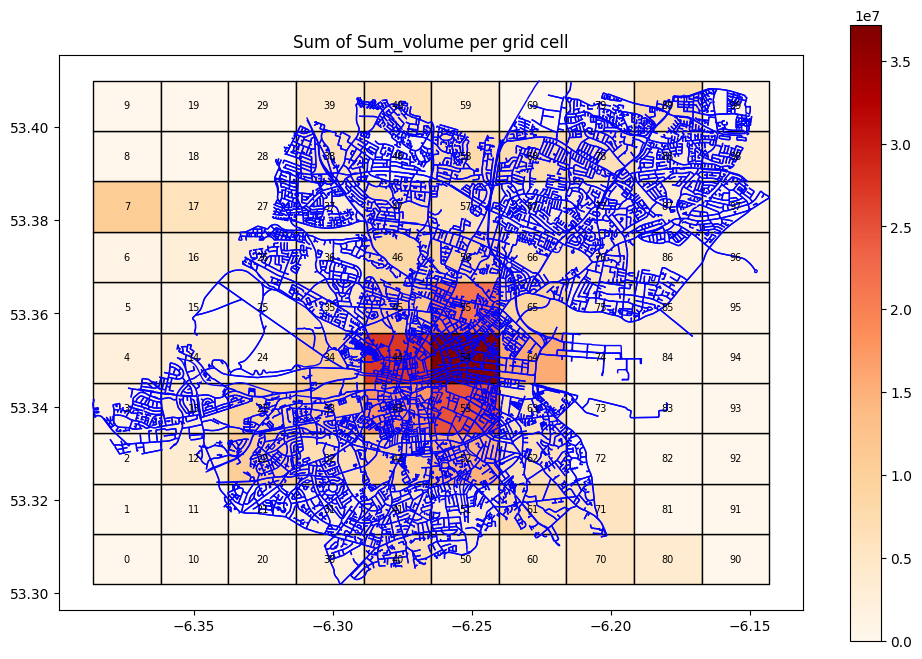

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
grid.plot(column='Sum_volume', ax=ax, cmap='OrRd', legend=True, edgecolor='k')
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')

for idx, row in grid.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, str(row.name), fontsize=7, color="black",
                ha="center", va="center")
        
plt.title("Sum of Sum_volume per grid cell")
plt.show()

In [15]:
joined_eval.head()


,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-03-01 00:00:00,897
1,3.0,2025-03-01 01:00:00,551
2,3.0,2025-03-01 02:00:00,492
3,3.0,2025-03-01 03:00:00,272
4,3.0,2025-03-01 04:00:00,247


In [17]:
pivoted = joined_eval.pivot(index = "End_Time", columns= "Grid_ID", values = "Sum_Volume")
pivoted.head()

Grid_ID,3.0,4.0,6.0,7.0,12.0,13.0,14.0,16.0,17.0,21.0,...,80.0,85.0,86.0,87.0,88.0,89.0,96.0,97.0,98.0,99.0
End_Time,,,,,,,,,,,,,,,,,,,,,
2025-03-01 00:00:00,897.0,977.0,467.0,6680.0,1300.0,1838.0,1352.0,1260.0,2259.0,160.0,...,2107.0,1581.0,758.0,2379.0,1587.0,3316.0,726.0,558.0,2185.0,382.0
2025-03-01 01:00:00,551.0,627.0,326.0,5218.0,903.0,1292.0,816.0,1074.0,1497.0,118.0,...,1695.0,1388.0,620.0,2158.0,1052.0,2352.0,557.0,442.0,1361.0,278.0
2025-03-01 02:00:00,492.0,544.0,270.0,4572.0,701.0,1116.0,591.0,655.0,1145.0,83.0,...,1268.0,896.0,516.0,2003.0,826.0,1863.0,425.0,347.0,1145.0,229.0
2025-03-01 03:00:00,272.0,326.0,176.0,1788.0,614.0,815.0,485.0,485.0,805.0,39.0,...,764.0,591.0,294.0,1471.0,540.0,1223.0,238.0,168.0,650.0,110.0
2025-03-01 04:00:00,247.0,250.0,101.0,3004.0,565.0,549.0,411.0,242.0,920.0,28.0,...,616.0,392.0,212.0,1287.0,443.0,1144.0,196.0,147.0,611.0,142.0


In [43]:
regress54_train = pivoted.copy()
for lag in range(1, 11):  # last 10 days
    regress54_train[f'Grid54_lag{lag}'] = regress54_train[54].shift(lag*24)

# Optionally drop rows with NaN (because the first 10 rows will have missing lag data)
regress54_train = regress54_train.dropna(subset=[f'Grid54_lag{lag}' for lag in range(1, 11)])

In [44]:
regress54_test = pivoted_test.copy()
for lag in range(1, 11):  # last 10 days
    regress54_test[f'Grid54_lag{lag}'] = regress54_test[54].shift(lag*24)

# Optionally drop rows with NaN (because the first 10 rows will have missing lag data)
regress54_test = regress54_test.dropna(subset=[f'Grid54_lag{lag}' for lag in range(1, 11)])

In [45]:
# Convert End_Time to numeric (if it's index)
for df in [regress54_train, regress54_test]:
    df['End_Time_num'] = pd.to_datetime(df.index).astype('int64') // 10**9

# Features: all lag columns + End_Time_num
lag_cols = [col for col in regress54_train.columns if '54_lag' in str(col)]
feature_cols = [col for col in regress54_train.columns if col != 54]

# Drop rows with NaNs in train/test
X_train = regress54_train[feature_cols].dropna()
y_train = regress54_train.loc[X_train.index, 54]

X_test = regress54_test[feature_cols].dropna()
y_test = regress54_test.loc[X_test.index, 54] if 54 in regress54_test else None

# Fix column types for sklearn
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
regress54_test.loc[X_test.index, 'Pred_54'] = y_pred

# Output
if y_test is not None:
    # Show actual vs predicted
    results = pd.DataFrame({'Actual': y_test.loc[X_test.index], 'Predicted': y_pred})
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    print("Test RMSE:", np.sqrt(mse))
    print(results.head(10))
else:
    # Only predicted values available
    print("No actual values for GridID 54 in test set. Only predictions:")
    print(pd.DataFrame({'Predicted': y_pred}).head(10))

Test RMSE: 1936.4519876336194
                      Actual     Predicted
End_Time                                  
2025-05-11 00:00:00  26547.0  26866.538744
2025-05-11 01:00:00  23587.0  24876.374645
2025-05-11 02:00:00  20084.0  19754.941827
2025-05-11 03:00:00  18015.0  18375.197949
2025-05-11 04:00:00  17157.0  17535.842138
2025-05-11 05:00:00  13811.0  12622.729000
2025-05-11 06:00:00  12084.0  13301.007325
2025-05-11 07:00:00  17826.0  16208.115064
2025-05-11 08:00:00  20399.0  21558.200721
2025-05-11 09:00:00  23981.0  24505.389509


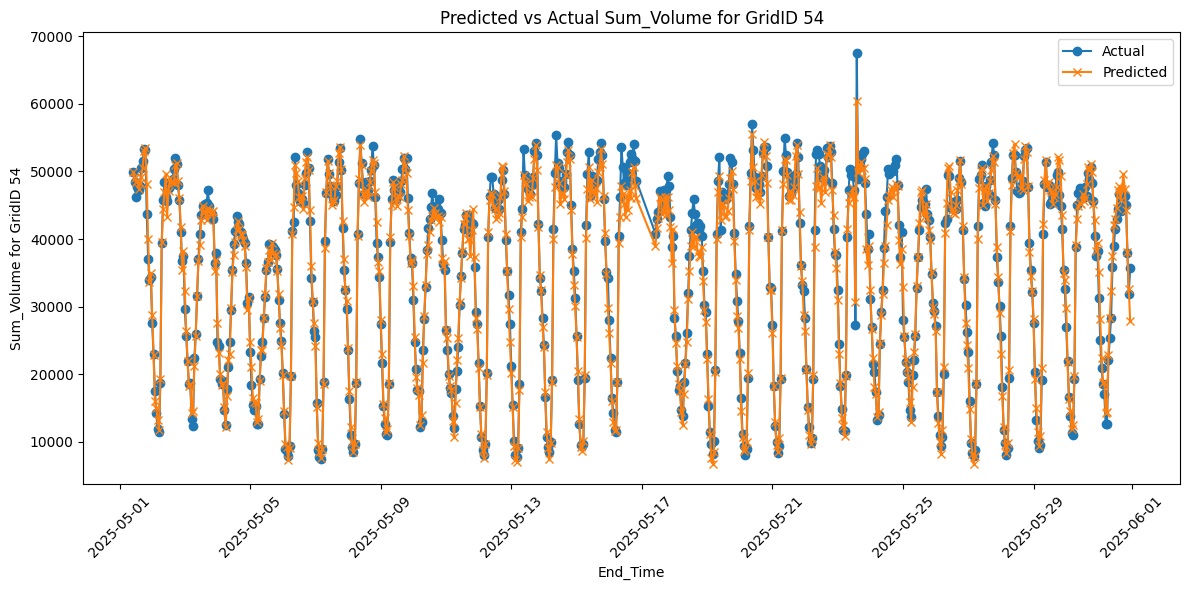

In [38]:
# Ensure End_Time is a datetime index
regress54_test.index = pd.to_datetime(regress54_test.index)

# Select only rows corresponding to X_test (aligned with predictions)
plot_df = regress54_test.loc[X_test.index, ['Pred_54', 54]].copy()
plot_df.rename(columns={54: 'Actual'}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', marker='o')
plt.plot(plot_df.index, plot_df['Pred_54'], label='Predicted', marker='x')
plt.xlabel('End_Time')
plt.ylabel('Sum_Volume for GridID 54')
plt.title('Predicted vs Actual Sum_Volume for GridID 54')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()










In [48]:
for df in [regress54_train, regress54_test]:
    df['End_Time_num'] = pd.to_datetime(df.index).astype('int64') // 10**9

# Features: all lag columns + End_Time_num
lag_cols = [col for col in regress54_train.columns if '54_lag' in str(col)]
feature_cols = [col for col in regress54_train.columns if col != 54]

# Drop rows with NaNs in train/test
X_train = regress54_train[feature_cols].dropna()
y_train = regress54_train.loc[X_train.index, 54]

X_test = regress54_test[feature_cols].dropna()
y_test = regress54_test.loc[X_test.index, 54] if 54 in regress54_test else None

# Fix column types for sklearn
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Fit linear regression
model = Lasso(alpha=75.43)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
regress54_test.loc[X_test.index, 'Pred_54'] = y_pred

# Output
if y_test is not None:
    # Show actual vs predicted
    results = pd.DataFrame({'Actual': y_test.loc[X_test.index], 'Predicted': y_pred})
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    print("Test RMSE:", np.sqrt(mse))
    print(results.head(10))
else:
    # Only predicted values available
    print("No actual values for GridID 54 in test set. Only predictions:")
    print(pd.DataFrame({'Predicted': y_pred}).head(10))

Test RMSE: 1914.2774615968467
                      Actual     Predicted
End_Time                                  
2025-05-11 00:00:00  26547.0  26979.723965
2025-05-11 01:00:00  23587.0  25666.035581
2025-05-11 02:00:00  20084.0  19946.869405
2025-05-11 03:00:00  18015.0  18238.278327
2025-05-11 04:00:00  17157.0  18190.329289
2025-05-11 05:00:00  13811.0  13202.479637
2025-05-11 06:00:00  12084.0  10428.875448
2025-05-11 07:00:00  17826.0  16596.487926
2025-05-11 08:00:00  20399.0  22301.121245
2025-05-11 09:00:00  23981.0  25480.904847


C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.412e+08, tolerance: 1.703e+07
  model = cd_fast.enet_coordinate_descent(


In [47]:
# Select features: all columns except the target 54
feature_cols = [col for col in regress54_train.columns if col != 54]

# Align train/test and drop NaNs caused by lags
X_train = regress54_train[feature_cols].dropna()
y_train = regress54_train.loc[X_train.index, 54]

X_test = regress54_test[feature_cols].dropna()
y_test = regress54_test.loc[X_test.index, 54]

# Convert column names to string (required for sklearn)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Define a range of alphas to search over
alphas = np.logspace(-4, 2, 50)  # from 1e-4 to 100

# Create LassoCV model with 5-fold cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)

# Fit the model
lasso_cv.fit(X_train, y_train)

# Best alpha found
print("Optimal alpha:", lasso_cv.alpha_)

# Predict on test set
y_pred = lasso_cv.predict(X_test)

# Save predictions to test dataframe
regress54_test.loc[X_test.index, 'Pred_54_Lasso'] = y_pred

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

# Optional: show first 10 actual vs predicted
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head(10))

C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.514e+08, tolerance: 1.296e+07
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.279e+07, tolerance: 1.296e+07
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feat

Optimal alpha: 75.43120063354607
Test RMSE: 1945.3507810138567
                      Actual     Predicted
End_Time                                  
2025-05-11 00:00:00  26547.0  26876.714299
2025-05-11 01:00:00  23587.0  24900.065282
2025-05-11 02:00:00  20084.0  19770.850154
2025-05-11 03:00:00  18015.0  18392.139815
2025-05-11 04:00:00  17157.0  17525.505808
2025-05-11 05:00:00  13811.0  12622.479747
2025-05-11 06:00:00  12084.0  13356.144256
2025-05-11 07:00:00  17826.0  16204.734355
2025-05-11 08:00:00  20399.0  21538.234042
2025-05-11 09:00:00  23981.0  24501.955828


C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.913e+08, tolerance: 1.703e+07
  model = cd_fast.enet_coordinate_descent(


In [42]:
pivoted.head()

Grid_ID,3.0,4.0,6.0,7.0,12.0,13.0,14.0,16.0,17.0,21.0,...,80.0,85.0,86.0,87.0,88.0,89.0,96.0,97.0,98.0,99.0
End_Time,,,,,,,,,,,,,,,,,,,,,
2025-03-01 00:00:00,897.0,977.0,467.0,6680.0,1300.0,1838.0,1352.0,1260.0,2259.0,160.0,...,2107.0,1581.0,758.0,2379.0,1587.0,3316.0,726.0,558.0,2185.0,382.0
2025-03-01 01:00:00,551.0,627.0,326.0,5218.0,903.0,1292.0,816.0,1074.0,1497.0,118.0,...,1695.0,1388.0,620.0,2158.0,1052.0,2352.0,557.0,442.0,1361.0,278.0
2025-03-01 02:00:00,492.0,544.0,270.0,4572.0,701.0,1116.0,591.0,655.0,1145.0,83.0,...,1268.0,896.0,516.0,2003.0,826.0,1863.0,425.0,347.0,1145.0,229.0
2025-03-01 03:00:00,272.0,326.0,176.0,1788.0,614.0,815.0,485.0,485.0,805.0,39.0,...,764.0,591.0,294.0,1471.0,540.0,1223.0,238.0,168.0,650.0,110.0
2025-03-01 04:00:00,247.0,250.0,101.0,3004.0,565.0,549.0,411.0,242.0,920.0,28.0,...,616.0,392.0,212.0,1287.0,443.0,1144.0,196.0,147.0,611.0,142.0
